In [36]:
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.data import Dataset, Iterator
from sklearn.metrics import f1_score, classification_report
import datetime
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Do not modify here ###### 

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)



## Data Preparing

In [2]:
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re

tknzr = TweetTokenizer()

def filter_tweet(tweet, token = tknzr):
    tweet = re.sub('https?:\/\/\S+','URLTOK',tweet.lower().strip()) # url
    tweet = re.sub('@(?:[a-zA-Z]+|[0-9 \/]+)', 'USRTOK', tweet) # mention
    tweet = re.sub('(\:|\=)(?:\)|\-|\(|D| )+', '', tweet) # emoticon
    return token.tokenize(tweet) # return tokenized



### Load positive data

#### Negative Tweets

In [3]:
with open('data/distance_supervised/sad') as f:
    sad_tweet = [filter_tweet(line) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_2_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_3_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]
print(len(sad_tweet))


815337


#### Positive Tweets

In [4]:
with open('data/distance_supervised/smile') as f:
    smile_tweet = [filter_tweet(line) for line in f.readlines()]
len(smile_tweet)

829183

In [5]:
# size filter
max_length = 60

sad_tweet = list(filter(lambda tweet: len(tweet) < max_length, sad_tweet))
print(len(sad_tweet))
smile_tweet = list(filter(lambda tweet: len(tweet) < max_length, smile_tweet))
print(len(smile_tweet))

814627
829162


### Build Dictionary

In [6]:
from collections import defaultdict
vocabulary_dict = {}
word_index = 1

for tweet in smile_tweet+sad_tweet:
    for word in tweet:
        if word not in vocabulary_dict:
            vocabulary_dict[word] = word_index
            word_index +=1

In [7]:
vocabulary_dict.get('URLTOK')

306940

In [8]:
# transform the tweet sentence to numerical representation
def word_transform(tweet_set, max_length = 60):
    set_array = []
    for tweet in tweet_set:
        tweet_array = [0] * max_length
        for i, word in enumerate(tweet):
            if vocabulary_dict.get(word):
                tweet_array[i] = vocabulary_dict[word]
            else:
                tweet_array[i] = 0
        set_array.append(tweet_array)
    return np.array(set_array)

In [9]:
sad_array = word_transform(sad_tweet, max_length = max_length)
print(sad_array.shape)
smile_array = word_transform(smile_tweet, max_length = max_length)
print(smile_array.shape)

(814627, 60)
(829162, 60)


In [10]:
smile_array[0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 19, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [11]:
sad_array[0]

array([330, 413,  74, 197,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [12]:
total_tweets = np.concatenate((smile_array[:sad_array.shape[0]], sad_array), axis=0)
total_labels = np.concatenate((np.zeros(sad_array.shape[0]), np.ones(sad_array.shape[0])), axis=0)

## Prepare Training + Testing Data

In [13]:
# from sklearn.model_selection import ShuffleSplit
# rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)

# senti_train = en_train['label'].as_matrix()
# senti_test  = en_test['label'].as_matrix()

# for train_index, test_index in rs.split(senti):
#     X_train = tweets[train_index]
#     y_train = senti[train_index]

#     X_test = tweets[test_index]
#     y_test = senti[test_index]
# X_train.shape

from sklearn.utils import shuffle
X_train, y_train = shuffle(total_tweets, total_labels, random_state=8)

y_train

array([ 0.,  1.,  1., ...,  0.,  1.,  1.])

# Load Pretrain Word2Vec Model (#DIM 200)

In [14]:
import pickle

# Load pre train Word2vec
wb_matrix = np.load("data/embed_tweets_en_200M_200D/embedding_matrix.npy")
print(wb_matrix.shape)
vocabulary_dict_ = pickle.load(open("data/embed_tweets_en_200M_200D/vocabulary.pickle", "rb"))
# print(len(vocabulary_dict))

(1859185, 200)


In [15]:
# print(vocabulary_dict.get('pairing'))
print(vocabulary_dict_.get('shiiit'))

(21519, 3253)


In [16]:
vocabulary_dict.get('pairing')

15142

In [17]:
 # initial matrix with random uniform
initW = np.random.uniform(-0.25,0.25,(len(vocabulary_dict)+1, wb_matrix.shape[1]))
# load any vectors from the word2vec
for word, index in vocabulary_dict.items():
#     print(word)
#     print(index)
    try:
        idx = vocabulary_dict_.get(word)[0]
    except:
        continue
#     print(idx)
    
    if idx != 0 and idx is not None:
        initW[index] = wb_matrix[idx]
        
initW.shape

(464547, 200)

In [32]:
del wb_matrix, vocabulary_dict_

# Distance Supervised Learning

In [19]:
n_input = max_length
n_output = 2
learning_rate = 1

embedding_size = initW.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 10
batch_size = 2048

In [20]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [52]:
# with tf.Session() as sess:
#     show_graph(tf.get_default_graph().as_graph_def())
#     # Initialize all variables
#     sess.run(tf.local_variables_initializer())
#     sess.run(tf.global_variables_initializer())
    
#     sess.run(word2vec.assign(initW))# Assign the pretrain word2vec


In [21]:
# prepare the training batch
train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat()
train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
train_next_batch = train_iterator.get_next()

In [22]:
round_of_epochs = int(X_train.shape[0]/batch_size)
print(round_of_epochs)

saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(initW))# Assign the pretrain word2vec
    for _ in range(epochs_num):
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train

        
    distance_supervised_embeddings = sess.run(word2vec)
    

795


### Dump

In [23]:
np.save('data/embedding/distance_supervised_800K_200M', distance_supervised_embeddings)
with open('data/embedding/distance_supervised_800K_200M.pickle', 'wb') as f:
    pickle.dump(vocabulary_dict,f)

### Load

In [ ]:
# Load pre train Word2vec
distance_supervised_embeddings = np.load("data/embedding/distance_supervised_800K_200M.npy")
print(distance_supervised_embeddings.shape)
vocabulary_dict = pickle.load(open("data/embedding/distance_supervised_800K_200M.pickle", "rb"))
print(len(vocabulary_dict))

## Distance Supervised Learning Comparsion

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [25]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word][0]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()
    
def draw_plot2(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()
    


Word2vec with distance supervised learning

Before


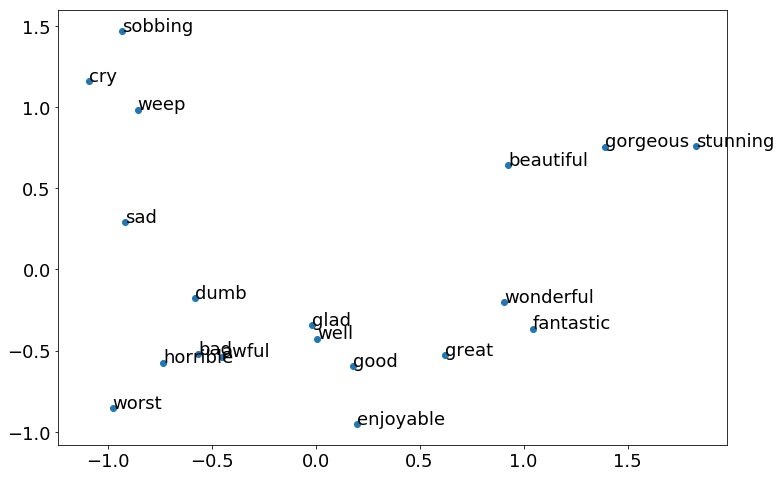

After


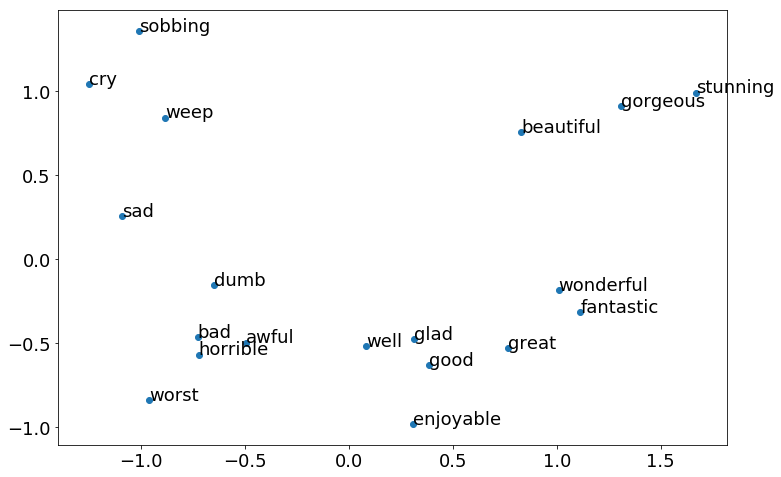

In [26]:
words = ['sad', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, wb_matrix, vocabulary_dict_)
print("After")
draw_plot2(words, distance_supervised_embeddings, vocabulary_dict)

# Supervised Learning

In [27]:
def polarity2label(polarity):
    if polarity =='negative':  return 0
    elif polarity =='neutral': return 1
    elif polarity =='positive':return 2 

In [28]:
# Load Training data
en_train = pd.read_csv('data/supervised_phase/en_full/en_full.tsv', delimiter='\t', names=["id", "lang", "polarity", "tweet"])
en_train.head()

# Load Testing data
en_test = pd.read_csv('data/supervised_phase/en_full/en_test.tsv', delimiter='\t', names=["id", "lang", "polarity", "tweet"])
en_test.head()


,id,lang,polarity,tweet
0,11378,en,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,11379,en,neutral,Order Go Set a Watchman in store or through ou...
2,11380,en,negative,If these runway renovations at the airport pre...
3,11381,en,neutral,If you could ask an onstage interview question...
4,11382,en,positive,A portion of book sales from our Harper Lee/Go...


In [29]:
en_train['label'] = en_train['polarity'].map(polarity2label)
en_train.head()

en_test['label'] = en_test['polarity'].map(polarity2label)
en_test.head()

,id,lang,polarity,tweet,label
0,11378,en,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",1
1,11379,en,neutral,Order Go Set a Watchman in store or through ou...,1
2,11380,en,negative,If these runway renovations at the airport pre...,0
3,11381,en,neutral,If you could ask an onstage interview question...,1
4,11382,en,positive,A portion of book sales from our Harper Lee/Go...,2


In [30]:
train_tweet = [filter_tweet(tweet) for tweet in en_train['tweet']]
test_tweet = [filter_tweet(tweet) for tweet in en_test['tweet']]


In [31]:

tweets_train = word_transform(train_tweet, max_length = max_length)
print(tweets_train.shape)
tweets_test = word_transform(test_tweet, max_length = max_length)
print(tweets_test.shape)

senti_train = en_train['label'].as_matrix()
senti_test  = en_test['label'].as_matrix()

(18044, 60)
(20632, 60)


### Build Model

In [33]:
n_input = max_length
n_output = 3
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 500
batch_size = 2048

In [43]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [63]:
# prepare the training batch
train_data = tf.contrib.data.Dataset.from_tensor_slices((tweets_train, senti_train)).batch(batch_size).repeat()
train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
train_next_batch = train_iterator.get_next()

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-18 17:18:12 -    1 epoch, loss:1.015, train accuracy:0.509, train f1 score:0.344, test f1 score:0.174
2017-11-18 17:18:19 -   11 epoch, loss:0.966, train accuracy:0.569, train f1 score:0.520, test f1 score:0.456
2017-11-18 17:18:25 -   21 epoch, loss:0.962, train accuracy:0.568, train f1 score:0.474, test f1 score:0.282
2017-11-18 17:18:31 -   31 epoch, loss:0.980, train accuracy:0.547, train f1 score:0.469, test f1 score:0.458
2017-11-18 17:18:38 -   41 epoch, loss:0.859, train accuracy:0.692, train f1 score:0.635, test f1 score:0.570
2017-11-18 17:18:44 -   51 epoch, loss:0.853, train accuracy:0.697, train f1 score:0.649, test f1 score:0.570
2017-11-18 17:18:51 -   61 epoch, loss:0.839, train accuracy:0.712, train f1 score:0.656, test f1 score:0.528
2017-11-18 17:18:57 -   71 epoch, loss:0.843, train accuracy:0.703, train f1 score:0.639, test f1 score:0.570
2017-11-18 17:19:03 -   81 epoch, loss:0.875, train accuracy:0.669, train f1 score:0.618, test f1 score:0.562
2017-11-18

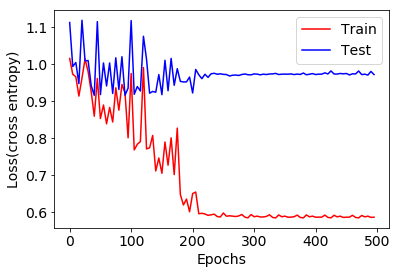

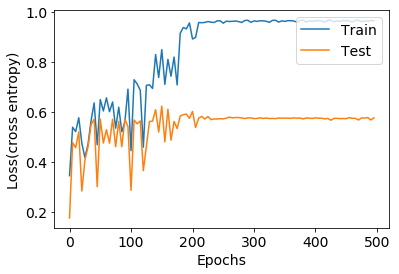

In [61]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 5)
saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
        if epochs % 5 ==0:
            loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:train, y:label})
            t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
            train_loss.append(loss)
            test_loss.append(t_loss)
            train_f1.append(f1_score(label, pred, average='weighted'))
            test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
        if epochs % 10 ==0:
            print("{} - {:4d} epoch, loss:{:.3f}, train accuracy:{:.3f}, train f1 score:{:.3f}, test f1 score:{:.3f}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                epochs+1,
                loss, 
                acc,
                f1_score(label, pred, average='weighted'),
                f1_score(senti_test, t_pred, average='weighted')
                )
            )
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 score')
    plt.show()

    

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-18 17:23:35 -    1 epoch, loss:1.015, train accuracy:0.509, train f1 score:0.344, test f1 score:0.174
2017-11-18 17:23:44 -   11 epoch, loss:0.964, train accuracy:0.574, train f1 score:0.527, test f1 score:0.471
2017-11-18 17:23:53 -   21 epoch, loss:0.947, train accuracy:0.583, train f1 score:0.509, test f1 score:0.336
2017-11-18 17:24:02 -   31 epoch, loss:0.971, train accuracy:0.560, train f1 score:0.483, test f1 score:0.468
2017-11-18 17:24:11 -   41 epoch, loss:0.842, train accuracy:0.708, train f1 score:0.650, test f1 score:0.572
2017-11-18 17:24:20 -   51 epoch, loss:0.837, train accuracy:0.713, train f1 score:0.663, test f1 score:0.573
2017-11-18 17:24:29 -   61 epoch, loss:0.827, train accuracy:0.720, train f1 score:0.667, test f1 score:0.565
2017-11-18 17:24:38 -   71 epoch, loss:0.842, train accuracy:0.705, train f1 score:0.641, test f1 score:0.568
2017-11-18 17:24:47 -   81 epoch, loss:0.824, train accuracy:0.730, train f1 score:0.671, test f1 score:0.553
2017-11-18

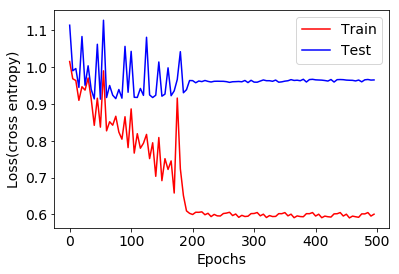

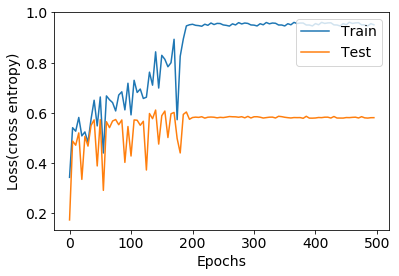

In [64]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 5)
saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
        if epochs % 5 ==0:
            loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:train, y:label})
            t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
            train_loss.append(loss)
            test_loss.append(t_loss)
            train_f1.append(f1_score(label, pred, average='weighted'))
            test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
        if epochs % 10 ==0:
            print("{} - {:4d} epoch, loss:{:.3f}, train accuracy:{:.3f}, train f1 score:{:.3f}, test f1 score:{:.3f}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                epochs+1,
                loss, 
                acc,
                f1_score(label, pred, average='weighted'),
                f1_score(senti_test, t_pred, average='weighted')
                )
            )
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 score')
    plt.show()

    

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-22 00:01:28 -    1 epoch, loss:1.077, valid f1 score:0.196, test f1 score:0.174
2017-11-22 00:01:35 -   11 epoch, loss:1.045, valid f1 score:0.345, test f1 score:0.378
2017-11-22 00:01:41 -   21 epoch, loss:0.967, valid f1 score:0.521, test f1 score:0.550
2017-11-22 00:01:48 -   31 epoch, loss:1.077, valid f1 score:0.338, test f1 score:0.357
2017-11-22 00:01:54 -   41 epoch, loss:0.952, valid f1 score:0.531, test f1 score:0.545
2017-11-22 00:02:00 -   51 epoch, loss:1.010, valid f1 score:0.445, test f1 score:0.468
2017-11-22 00:02:07 -   61 epoch, loss:0.918, valid f1 score:0.571, test f1 score:0.566
2017-11-22 00:02:13 -   71 epoch, loss:0.940, valid f1 score:0.540, test f1 score:0.546
2017-11-22 00:02:20 -   81 epoch, loss:0.902, valid f1 score:0.584, test f1 score:0.570
2017-11-22 00:02:26 -   91 epoch, loss:0.971, valid f1 score:0.504, test f1 score:0.502
2017-11-22 00:02:33 -  101 epoch, loss:1.031, valid f1 score:0.416, test f1 score:0.421
2017-11-22 00:02:39 -  111 epoch

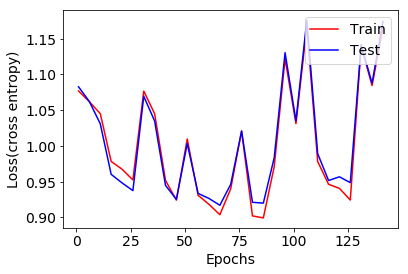

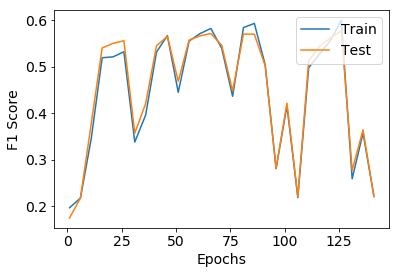

2017-11-22 00:03:01 -    1 epoch, loss:1.094, valid f1 score:0.158, test f1 score:0.174
2017-11-22 00:03:07 -   11 epoch, loss:0.963, valid f1 score:0.529, test f1 score:0.531
2017-11-22 00:03:14 -   21 epoch, loss:0.979, valid f1 score:0.515, test f1 score:0.551
2017-11-22 00:03:20 -   31 epoch, loss:1.029, valid f1 score:0.442, test f1 score:0.489
2017-11-22 00:03:27 -   41 epoch, loss:0.936, valid f1 score:0.565, test f1 score:0.566
2017-11-22 00:03:33 -   51 epoch, loss:1.151, valid f1 score:0.249, test f1 score:0.297
2017-11-22 00:03:40 -   61 epoch, loss:1.031, valid f1 score:0.442, test f1 score:0.472
2017-11-22 00:03:46 -   71 epoch, loss:0.907, valid f1 score:0.594, test f1 score:0.575
2017-11-22 00:03:53 -   81 epoch, loss:1.186, valid f1 score:0.209, test f1 score:0.253
2017-11-22 00:03:59 -   91 epoch, loss:0.907, valid f1 score:0.594, test f1 score:0.571
2017-11-22 00:04:05 -  101 epoch, loss:0.894, valid f1 score:0.609, test f1 score:0.572
2017-11-22 00:04:12 -  111 epoch

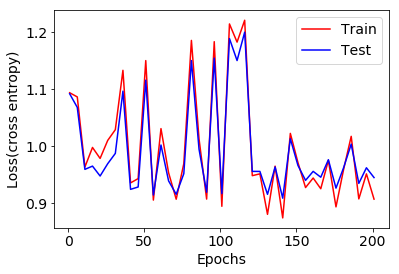

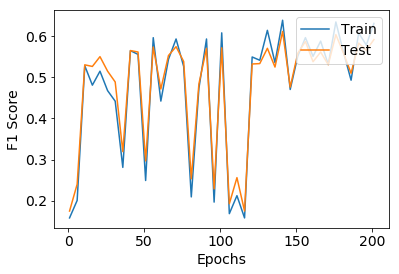

2017-11-22 00:05:12 -    1 epoch, loss:1.105, valid f1 score:0.170, test f1 score:0.174
2017-11-22 00:05:19 -   11 epoch, loss:0.991, valid f1 score:0.484, test f1 score:0.489
2017-11-22 00:05:25 -   21 epoch, loss:0.932, valid f1 score:0.587, test f1 score:0.559
2017-11-22 00:05:32 -   31 epoch, loss:1.084, valid f1 score:0.342, test f1 score:0.366
2017-11-22 00:05:38 -   41 epoch, loss:0.916, valid f1 score:0.588, test f1 score:0.567
2017-11-22 00:05:45 -   51 epoch, loss:0.924, valid f1 score:0.582, test f1 score:0.564
2017-11-22 00:05:51 -   61 epoch, loss:0.874, valid f1 score:0.630, test f1 score:0.572
2017-11-22 00:05:58 -   71 epoch, loss:1.181, valid f1 score:0.206, test f1 score:0.235
2017-11-22 00:06:04 -   81 epoch, loss:0.851, valid f1 score:0.646, test f1 score:0.568
2017-11-22 00:06:11 -   91 epoch, loss:0.850, valid f1 score:0.649, test f1 score:0.585
2017-11-22 00:06:17 -  101 epoch, loss:0.980, valid f1 score:0.538, test f1 score:0.563
2017-11-22 00:06:24 -  111 epoch

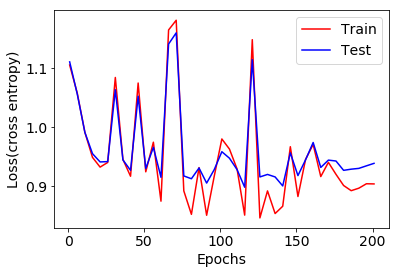

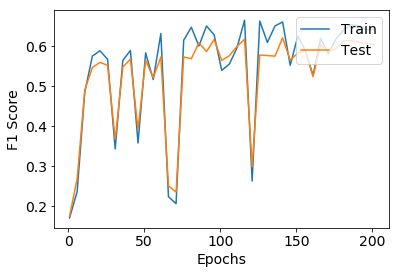

2017-11-22 00:07:24 -    1 epoch, loss:1.105, valid f1 score:0.243, test f1 score:0.174
2017-11-22 00:07:31 -   11 epoch, loss:0.962, valid f1 score:0.528, test f1 score:0.533
2017-11-22 00:07:37 -   21 epoch, loss:0.940, valid f1 score:0.544, test f1 score:0.538
2017-11-22 00:07:44 -   31 epoch, loss:0.944, valid f1 score:0.536, test f1 score:0.527
2017-11-22 00:07:50 -   41 epoch, loss:0.971, valid f1 score:0.483, test f1 score:0.474
2017-11-22 00:07:57 -   51 epoch, loss:0.898, valid f1 score:0.593, test f1 score:0.571
2017-11-22 00:08:03 -   61 epoch, loss:0.978, valid f1 score:0.477, test f1 score:0.454
2017-11-22 00:08:10 -   71 epoch, loss:0.932, valid f1 score:0.545, test f1 score:0.525
2017-11-22 00:08:16 -   81 epoch, loss:0.896, valid f1 score:0.593, test f1 score:0.567
2017-11-22 00:08:23 -   91 epoch, loss:0.995, valid f1 score:0.457, test f1 score:0.415
2017-11-22 00:08:29 -  101 epoch, loss:1.016, valid f1 score:0.429, test f1 score:0.384
2017-11-22 00:08:36 -  111 epoch

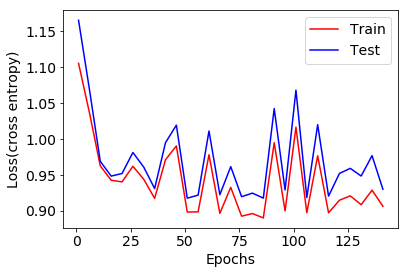

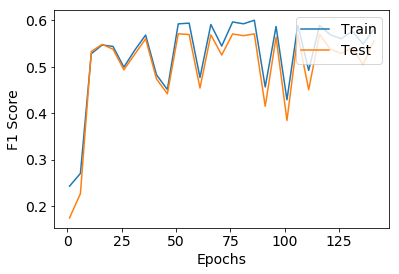

2017-11-22 00:08:58 -    1 epoch, loss:1.124, valid f1 score:0.228, test f1 score:0.174
2017-11-22 00:09:04 -   11 epoch, loss:0.994, valid f1 score:0.459, test f1 score:0.465
2017-11-22 00:09:11 -   21 epoch, loss:0.983, valid f1 score:0.474, test f1 score:0.482
2017-11-22 00:09:17 -   31 epoch, loss:0.958, valid f1 score:0.511, test f1 score:0.521
2017-11-22 00:09:24 -   41 epoch, loss:0.921, valid f1 score:0.558, test f1 score:0.567
2017-11-22 00:09:30 -   51 epoch, loss:1.030, valid f1 score:0.396, test f1 score:0.382
2017-11-22 00:09:37 -   61 epoch, loss:0.909, valid f1 score:0.575, test f1 score:0.573
2017-11-22 00:09:43 -   71 epoch, loss:0.914, valid f1 score:0.571, test f1 score:0.565
2017-11-22 00:09:50 -   81 epoch, loss:1.088, valid f1 score:0.314, test f1 score:0.283
2017-11-22 00:09:56 -   91 epoch, loss:1.067, valid f1 score:0.348, test f1 score:0.313
2017-11-22 00:10:03 -  101 epoch, loss:0.911, valid f1 score:0.577, test f1 score:0.572
2017-11-22 00:10:09 -  111 epoch

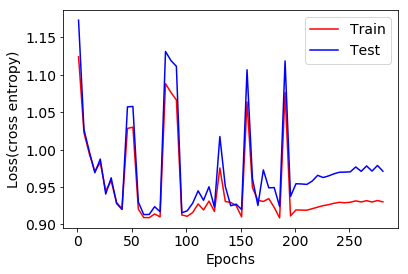

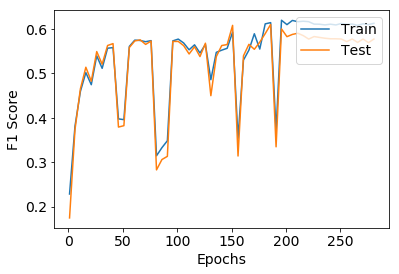

2017-11-22 00:12:02 -    1 epoch, loss:1.074, valid f1 score:0.269, test f1 score:0.174
2017-11-22 00:12:08 -   11 epoch, loss:0.994, valid f1 score:0.483, test f1 score:0.506
2017-11-22 00:12:15 -   21 epoch, loss:0.978, valid f1 score:0.501, test f1 score:0.560
2017-11-22 00:12:21 -   31 epoch, loss:0.968, valid f1 score:0.504, test f1 score:0.552
2017-11-22 00:12:28 -   41 epoch, loss:1.033, valid f1 score:0.378, test f1 score:0.306
2017-11-22 00:12:34 -   51 epoch, loss:0.969, valid f1 score:0.512, test f1 score:0.575
2017-11-22 00:12:41 -   61 epoch, loss:0.967, valid f1 score:0.513, test f1 score:0.567
2017-11-22 00:12:47 -   71 epoch, loss:0.969, valid f1 score:0.514, test f1 score:0.576
2017-11-22 00:12:54 -   81 epoch, loss:1.032, valid f1 score:0.389, test f1 score:0.327
2017-11-22 00:13:00 -   91 epoch, loss:1.071, valid f1 score:0.330, test f1 score:0.231
2017-11-22 00:13:07 -  101 epoch, loss:1.079, valid f1 score:0.313, test f1 score:0.215
2017-11-22 00:13:13 -  111 epoch

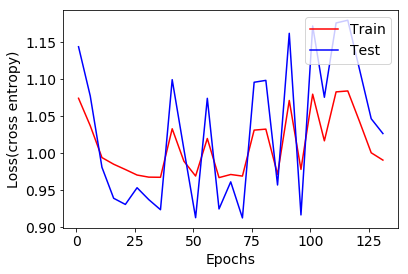

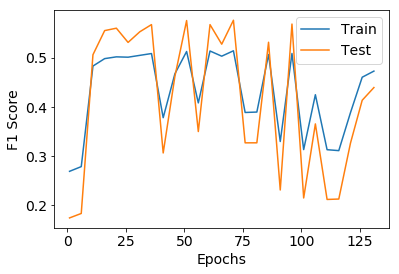

2017-11-22 00:13:29 -    1 epoch, loss:0.998, valid f1 score:0.373, test f1 score:0.174
2017-11-22 00:13:36 -   11 epoch, loss:0.956, valid f1 score:0.539, test f1 score:0.472
2017-11-22 00:13:42 -   21 epoch, loss:0.994, valid f1 score:0.491, test f1 score:0.559
2017-11-22 00:13:49 -   31 epoch, loss:0.955, valid f1 score:0.529, test f1 score:0.562
2017-11-22 00:13:55 -   41 epoch, loss:0.961, valid f1 score:0.527, test f1 score:0.569
2017-11-22 00:14:02 -   51 epoch, loss:0.965, valid f1 score:0.532, test f1 score:0.570
2017-11-22 00:14:08 -   61 epoch, loss:0.947, valid f1 score:0.498, test f1 score:0.306
2017-11-22 00:14:15 -   71 epoch, loss:0.935, valid f1 score:0.561, test f1 score:0.539
2017-11-22 00:14:21 -   81 epoch, loss:0.928, valid f1 score:0.582, test f1 score:0.551
2017-11-22 00:14:28 -   91 epoch, loss:0.920, valid f1 score:0.564, test f1 score:0.404
2017-11-22 00:14:34 -  101 epoch, loss:0.915, valid f1 score:0.573, test f1 score:0.441
2017-11-22 00:14:41 -  111 epoch

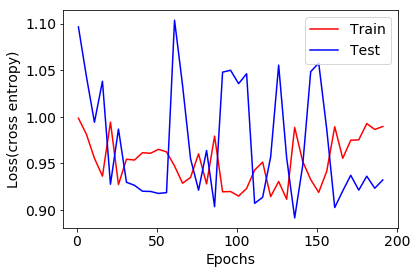

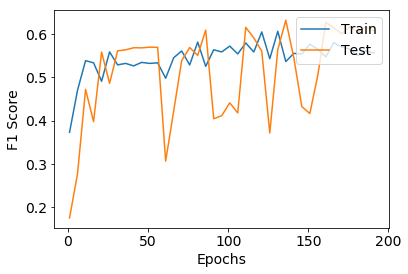

2017-11-22 00:15:35 -    1 epoch, loss:1.028, valid f1 score:0.311, test f1 score:0.174
2017-11-22 00:15:42 -   11 epoch, loss:0.980, valid f1 score:0.490, test f1 score:0.438
2017-11-22 00:15:48 -   21 epoch, loss:0.962, valid f1 score:0.514, test f1 score:0.456
2017-11-22 00:15:55 -   31 epoch, loss:0.975, valid f1 score:0.510, test f1 score:0.563
2017-11-22 00:16:01 -   41 epoch, loss:0.978, valid f1 score:0.465, test f1 score:0.352
2017-11-22 00:16:08 -   51 epoch, loss:0.960, valid f1 score:0.524, test f1 score:0.559
2017-11-22 00:16:14 -   61 epoch, loss:0.957, valid f1 score:0.516, test f1 score:0.450
2017-11-22 00:16:21 -   71 epoch, loss:0.954, valid f1 score:0.524, test f1 score:0.470
2017-11-22 00:16:27 -   81 epoch, loss:0.977, valid f1 score:0.507, test f1 score:0.572
2017-11-22 00:16:34 -   91 epoch, loss:0.988, valid f1 score:0.501, test f1 score:0.570
2017-11-22 00:16:40 -  101 epoch, loss:0.984, valid f1 score:0.508, test f1 score:0.577
2017-11-22 00:16:47 -  111 epoch

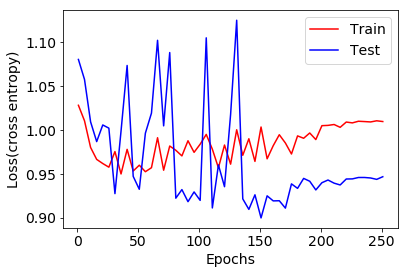

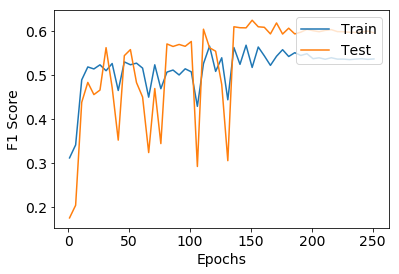

2017-11-22 00:18:20 -    1 epoch, loss:1.022, valid f1 score:0.337, test f1 score:0.174
2017-11-22 00:18:27 -   11 epoch, loss:0.976, valid f1 score:0.504, test f1 score:0.447
2017-11-22 00:18:33 -   21 epoch, loss:0.958, valid f1 score:0.513, test f1 score:0.430
2017-11-22 00:18:40 -   31 epoch, loss:0.955, valid f1 score:0.525, test f1 score:0.487
2017-11-22 00:18:46 -   41 epoch, loss:1.008, valid f1 score:0.474, test f1 score:0.571
2017-11-22 00:18:53 -   51 epoch, loss:0.979, valid f1 score:0.451, test f1 score:0.288
2017-11-22 00:18:59 -   61 epoch, loss:0.952, valid f1 score:0.535, test f1 score:0.508
2017-11-22 00:19:06 -   71 epoch, loss:0.992, valid f1 score:0.504, test f1 score:0.574
2017-11-22 00:19:12 -   81 epoch, loss:0.962, valid f1 score:0.531, test f1 score:0.554
2017-11-22 00:19:19 -   91 epoch, loss:0.957, valid f1 score:0.536, test f1 score:0.530
2017-11-22 00:19:25 -  101 epoch, loss:0.953, valid f1 score:0.529, test f1 score:0.427
2017-11-22 00:19:32 -  111 epoch

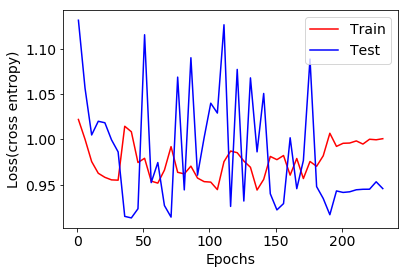

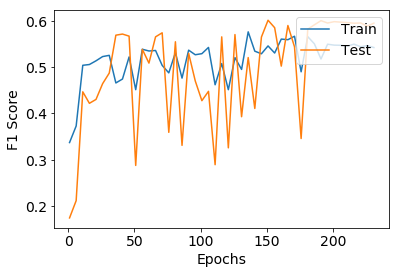

2017-11-22 00:20:52 -    1 epoch, loss:1.023, valid f1 score:0.330, test f1 score:0.174
2017-11-22 00:20:58 -   11 epoch, loss:0.971, valid f1 score:0.481, test f1 score:0.387
2017-11-22 00:21:05 -   21 epoch, loss:0.969, valid f1 score:0.470, test f1 score:0.357
2017-11-22 00:21:11 -   31 epoch, loss:0.952, valid f1 score:0.523, test f1 score:0.475
2017-11-22 00:21:18 -   41 epoch, loss:0.953, valid f1 score:0.529, test f1 score:0.537
2017-11-22 00:21:24 -   51 epoch, loss:0.964, valid f1 score:0.519, test f1 score:0.565
2017-11-22 00:21:31 -   61 epoch, loss:0.975, valid f1 score:0.463, test f1 score:0.346
2017-11-22 00:21:37 -   71 epoch, loss:0.975, valid f1 score:0.512, test f1 score:0.573
2017-11-22 00:21:44 -   81 epoch, loss:0.971, valid f1 score:0.519, test f1 score:0.569
2017-11-22 00:21:50 -   91 epoch, loss:0.964, valid f1 score:0.567, test f1 score:0.582
2017-11-22 00:21:57 -  101 epoch, loss:0.974, valid f1 score:0.541, test f1 score:0.608
2017-11-22 00:22:03 -  111 epoch

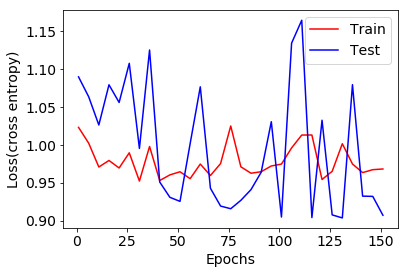

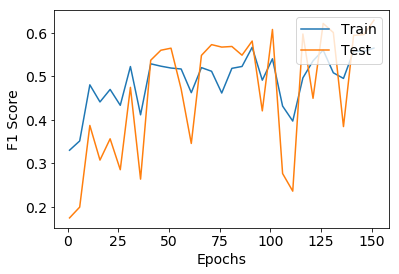

Average Validation F1 Score:0.5891312869702745
Average Testing F1 Score:0.5809871842772718
Average Top 5 Testing:0.5977873852984189


In [37]:
kf = KFold(n_splits=10)  # indice of 5 fold
saver = tf.train.Saver() # to store the model

early_stop_num = 5
best_valid_f1 = 0.0
best_test_f1 = 0.0

best_train_loss=None
best_test_loss=None
round_best_valid_f1_list = []
round_best_test_f1_list = []
x_axis = np.arange(0., epochs_num, 5)

with tf.Session() as sess:
    for cross_validation_round, (train_index, valid_index) in enumerate(kf.split(tweets_train, senti_train)):
        X_train_folds = tweets_train[train_index]
        y_train_folds = senti_train[train_index]
        X_valid_folds = tweets_train[valid_index]
        y_valid_folds = senti_train[valid_index]
        
        # prepare the training batch
        train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train_folds, y_train_folds)).batch(batch_size).repeat()
        train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
        train_next_batch = train_iterator.get_next()
        
        round_of_epochs = int(tweets_train.shape[0]/batch_size)
        train_loss = []
        test_loss  = []
        train_f1 = []
        test_f1 = []
        local_x_axis = []
        local_best_valid_f1 = 0.0
        local_best_test_f1 = 0.0
        not_better_count = 0
        
        # Initialize all variables
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())

        sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec

        for epochs in range(epochs_num): # starting the training process and set the epochs_num
            for _ in range(round_of_epochs):
                train, label = sess.run(train_next_batch) # Get the mini-batch data sample
                sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
            if epochs % 5 ==0:
                loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:X_valid_folds, y:y_valid_folds})
                t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
                train_loss.append(loss)
                test_loss.append(t_loss)
                train_f1.append(f1_score(y_valid_folds, pred, average='weighted'))
                test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
                local_x_axis.append(epochs+1)
            if epochs % 10 ==0:
                print("{} - {:4d} epoch, loss:{:.3f}, valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    epochs+1,
                    loss,
                    f1_score(y_valid_folds, pred, average='weighted'),
                    f1_score(senti_test, t_pred, average='weighted')
                    )
                )
                if train_f1[-1] > local_best_valid_f1:
                    local_best_valid_f1 = train_f1[-1] # assign the best valid value
                    local_best_test_f1 = test_f1[-1] # assign the test value of best valid value
                    not_better_count = 0 # reset the counter
                    
                    # if better then current best one, record it
                    if train_f1[-1] > best_valid_f1:
                        best_valid_f1 = train_f1[-1]
                    if test_f1[-1] > best_test_f1:
                        best_test_f1 = test_f1[-1]
                else:
                    not_better_count += 1
                    if not_better_count > 5:
                        print("No.{} Folds, Early Stop, {} Eopchs, best valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                            cross_validation_round+1,
                            epochs+1,
                            local_best_valid_f1,
                            local_best_test_f1
                        ))
                        round_best_valid_f1_list.append(local_best_valid_f1)
                        round_best_test_f1_list.append(local_best_test_f1)
                        

                        plt.rcParams['font.size'] = 14
                        plt.plot(local_x_axis, train_loss, 'r', local_x_axis, test_loss, 'b')
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('Loss(cross entropy)')
                        plt.show()
                        plt.clf()
                        plt.plot(local_x_axis, train_f1, local_x_axis, test_f1)
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('F1 Score')
                        plt.show()
                        break
print("Average Validation F1 Score:{}\nAverage Testing F1 Score:{}\nAverage Top 5 Testing:{}".format(
            sum(round_best_valid_f1_list)/10.0,
            sum(round_best_test_f1_list)/10.0,
            sum(sorted(round_best_test_f1_list, reverse=True)[:5])/5
        )
     )

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-22 13:29:09 -    1 epoch, loss:1.077, valid f1 score:0.196, test f1 score:0.174
2017-11-22 13:29:19 -   11 epoch, loss:0.995, valid f1 score:0.492, test f1 score:0.523
2017-11-22 13:29:28 -   21 epoch, loss:0.953, valid f1 score:0.539, test f1 score:0.560
2017-11-22 13:29:37 -   31 epoch, loss:1.055, valid f1 score:0.374, test f1 score:0.395
2017-11-22 13:29:46 -   41 epoch, loss:1.102, valid f1 score:0.308, test f1 score:0.324
2017-11-22 13:29:55 -   51 epoch, loss:1.004, valid f1 score:0.461, test f1 score:0.475
2017-11-22 13:30:04 -   61 epoch, loss:0.905, valid f1 score:0.582, test f1 score:0.572
2017-11-22 13:30:13 -   71 epoch, loss:0.980, valid f1 score:0.490, test f1 score:0.503
2017-11-22 13:30:22 -   81 epoch, loss:1.045, valid f1 score:0.396, test f1 score:0.408
2017-11-22 13:30:31 -   91 epoch, loss:0.887, valid f1 score:0.599, test f1 score:0.568
2017-11-22 13:30:40 -  101 epoch, loss:0.886, valid f1 score:0.596, test f1 score:0.569
2017-11-22 13:30:49 -  111 epoch

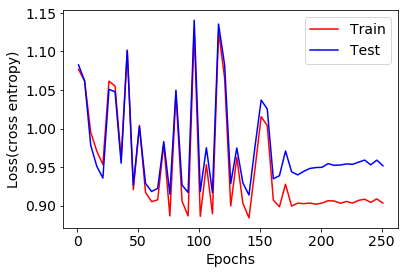

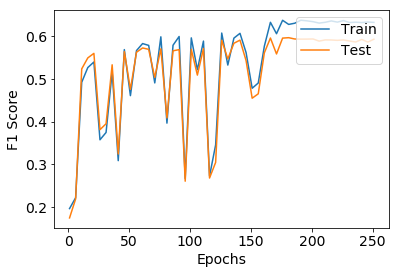

2017-11-22 13:32:59 -    1 epoch, loss:1.096, valid f1 score:0.158, test f1 score:0.174
2017-11-22 13:33:08 -   11 epoch, loss:1.009, valid f1 score:0.471, test f1 score:0.508
2017-11-22 13:33:17 -   21 epoch, loss:0.964, valid f1 score:0.535, test f1 score:0.560
2017-11-22 13:33:26 -   31 epoch, loss:0.999, valid f1 score:0.485, test f1 score:0.516
2017-11-22 13:33:36 -   41 epoch, loss:1.047, valid f1 score:0.413, test f1 score:0.458
2017-11-22 13:33:45 -   51 epoch, loss:1.008, valid f1 score:0.480, test f1 score:0.506
2017-11-22 13:33:54 -   61 epoch, loss:1.081, valid f1 score:0.373, test f1 score:0.410
2017-11-22 13:34:03 -   71 epoch, loss:1.141, valid f1 score:0.283, test f1 score:0.329
2017-11-22 13:34:12 -   81 epoch, loss:1.166, valid f1 score:0.236, test f1 score:0.286
No.2 Folds, Early Stop, 81 Eopchs, best valid f1 score:0.535, test f1 score:0.560


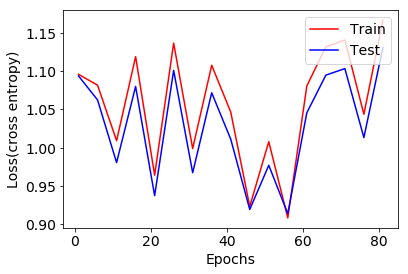

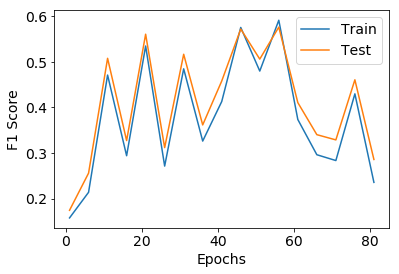

2017-11-22 13:34:15 -    1 epoch, loss:1.106, valid f1 score:0.170, test f1 score:0.174
2017-11-22 13:34:24 -   11 epoch, loss:0.959, valid f1 score:0.574, test f1 score:0.537
2017-11-22 13:34:33 -   21 epoch, loss:0.925, valid f1 score:0.592, test f1 score:0.566
2017-11-22 13:34:42 -   31 epoch, loss:0.920, valid f1 score:0.586, test f1 score:0.565
2017-11-22 13:34:51 -   41 epoch, loss:1.079, valid f1 score:0.364, test f1 score:0.397
2017-11-22 13:35:00 -   51 epoch, loss:0.943, valid f1 score:0.562, test f1 score:0.550
2017-11-22 13:35:10 -   61 epoch, loss:1.174, valid f1 score:0.215, test f1 score:0.246
2017-11-22 13:35:19 -   71 epoch, loss:0.949, valid f1 score:0.556, test f1 score:0.547
2017-11-22 13:35:28 -   81 epoch, loss:0.934, valid f1 score:0.567, test f1 score:0.558
No.3 Folds, Early Stop, 81 Eopchs, best valid f1 score:0.592, test f1 score:0.566


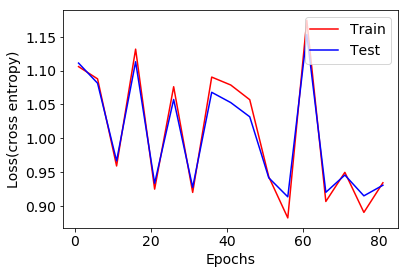

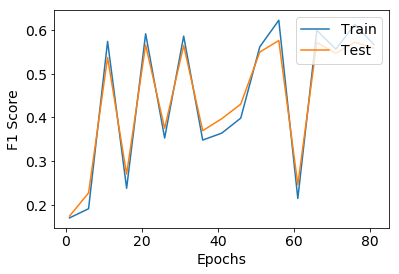

2017-11-22 13:35:31 -    1 epoch, loss:1.105, valid f1 score:0.243, test f1 score:0.174
2017-11-22 13:35:40 -   11 epoch, loss:0.954, valid f1 score:0.535, test f1 score:0.537
2017-11-22 13:35:49 -   21 epoch, loss:0.978, valid f1 score:0.468, test f1 score:0.451
2017-11-22 13:35:58 -   31 epoch, loss:0.917, valid f1 score:0.572, test f1 score:0.557
2017-11-22 13:36:07 -   41 epoch, loss:0.999, valid f1 score:0.446, test f1 score:0.417
2017-11-22 13:36:17 -   51 epoch, loss:1.016, valid f1 score:0.430, test f1 score:0.384
2017-11-22 13:36:26 -   61 epoch, loss:0.892, valid f1 score:0.597, test f1 score:0.576
2017-11-22 13:36:35 -   71 epoch, loss:1.087, valid f1 score:0.310, test f1 score:0.267
2017-11-22 13:36:44 -   81 epoch, loss:0.891, valid f1 score:0.597, test f1 score:0.573
2017-11-22 13:36:53 -   91 epoch, loss:0.965, valid f1 score:0.508, test f1 score:0.463
2017-11-22 13:37:02 -  101 epoch, loss:0.967, valid f1 score:0.507, test f1 score:0.455
2017-11-22 13:37:11 -  111 epoch

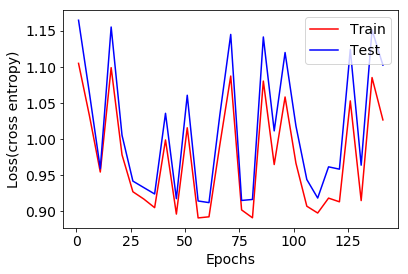

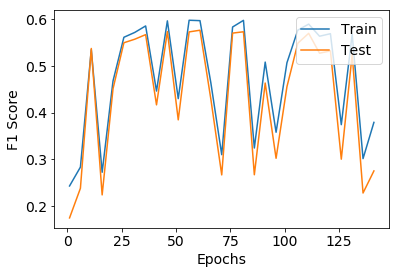

2017-11-22 13:37:42 -    1 epoch, loss:1.120, valid f1 score:0.228, test f1 score:0.174
2017-11-22 13:37:51 -   11 epoch, loss:1.104, valid f1 score:0.259, test f1 score:0.223
2017-11-22 13:38:00 -   21 epoch, loss:0.961, valid f1 score:0.515, test f1 score:0.524
2017-11-22 13:38:09 -   31 epoch, loss:0.963, valid f1 score:0.501, test f1 score:0.503
2017-11-22 13:38:18 -   41 epoch, loss:1.023, valid f1 score:0.409, test f1 score:0.393
2017-11-22 13:38:27 -   51 epoch, loss:0.914, valid f1 score:0.564, test f1 score:0.564
2017-11-22 13:38:36 -   61 epoch, loss:0.925, valid f1 score:0.558, test f1 score:0.552
2017-11-22 13:38:46 -   71 epoch, loss:0.913, valid f1 score:0.569, test f1 score:0.564
2017-11-22 13:38:55 -   81 epoch, loss:0.904, valid f1 score:0.580, test f1 score:0.576
2017-11-22 13:39:04 -   91 epoch, loss:0.906, valid f1 score:0.576, test f1 score:0.575
2017-11-22 13:39:13 -  101 epoch, loss:0.910, valid f1 score:0.572, test f1 score:0.574
2017-11-22 13:39:22 -  111 epoch

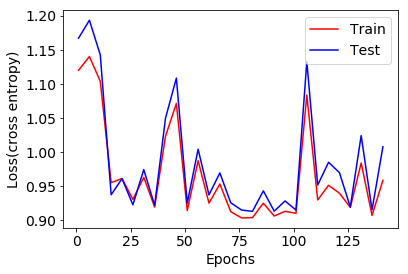

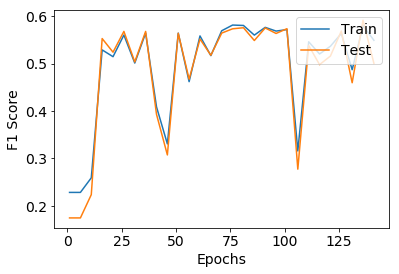

2017-11-22 13:39:53 -    1 epoch, loss:1.074, valid f1 score:0.269, test f1 score:0.174
2017-11-22 13:40:02 -   11 epoch, loss:1.015, valid f1 score:0.386, test f1 score:0.320
2017-11-22 13:40:11 -   21 epoch, loss:0.972, valid f1 score:0.500, test f1 score:0.539
2017-11-22 13:40:21 -   31 epoch, loss:0.968, valid f1 score:0.510, test f1 score:0.567
2017-11-22 13:40:30 -   41 epoch, loss:0.967, valid f1 score:0.514, test f1 score:0.572
2017-11-22 13:40:39 -   51 epoch, loss:0.968, valid f1 score:0.513, test f1 score:0.571
2017-11-22 13:40:48 -   61 epoch, loss:0.972, valid f1 score:0.513, test f1 score:0.578
2017-11-22 13:40:57 -   71 epoch, loss:1.031, valid f1 score:0.396, test f1 score:0.328
2017-11-22 13:41:06 -   81 epoch, loss:0.996, valid f1 score:0.465, test f1 score:0.451
2017-11-22 13:41:15 -   91 epoch, loss:0.972, valid f1 score:0.513, test f1 score:0.550
2017-11-22 13:41:24 -  101 epoch, loss:0.976, valid f1 score:0.502, test f1 score:0.530
No.6 Folds, Early Stop, 101 Eopc

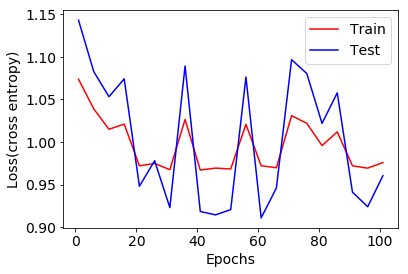

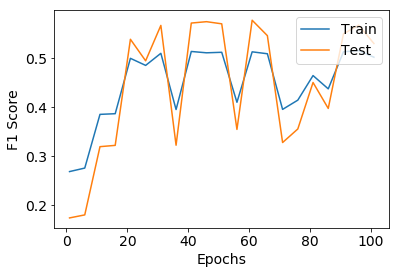

2017-11-22 13:41:28 -    1 epoch, loss:0.999, valid f1 score:0.373, test f1 score:0.174
2017-11-22 13:41:37 -   11 epoch, loss:0.945, valid f1 score:0.519, test f1 score:0.358
2017-11-22 13:41:46 -   21 epoch, loss:0.928, valid f1 score:0.556, test f1 score:0.479
2017-11-22 13:41:56 -   31 epoch, loss:0.967, valid f1 score:0.524, test f1 score:0.573
2017-11-22 13:42:05 -   41 epoch, loss:0.986, valid f1 score:0.507, test f1 score:0.577
2017-11-22 13:42:14 -   51 epoch, loss:0.961, valid f1 score:0.533, test f1 score:0.572
2017-11-22 13:42:23 -   61 epoch, loss:0.931, valid f1 score:0.559, test f1 score:0.521
2017-11-22 13:42:32 -   71 epoch, loss:0.957, valid f1 score:0.538, test f1 score:0.567
2017-11-22 13:42:41 -   81 epoch, loss:0.929, valid f1 score:0.543, test f1 score:0.397
2017-11-22 13:42:50 -   91 epoch, loss:0.931, valid f1 score:0.584, test f1 score:0.583
2017-11-22 13:42:59 -  101 epoch, loss:0.970, valid f1 score:0.540, test f1 score:0.581
2017-11-22 13:43:08 -  111 epoch

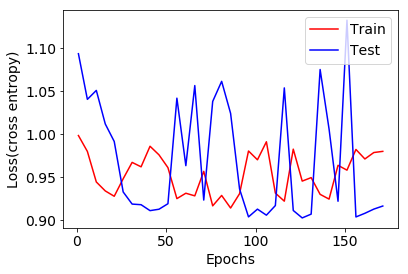

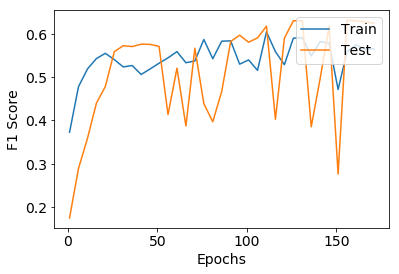

2017-11-22 13:44:08 -    1 epoch, loss:1.028, valid f1 score:0.311, test f1 score:0.174
2017-11-22 13:44:18 -   11 epoch, loss:0.978, valid f1 score:0.510, test f1 score:0.483
2017-11-22 13:44:27 -   21 epoch, loss:0.961, valid f1 score:0.514, test f1 score:0.459
2017-11-22 13:44:36 -   31 epoch, loss:0.959, valid f1 score:0.513, test f1 score:0.440
2017-11-22 13:44:45 -   41 epoch, loss:0.952, valid f1 score:0.530, test f1 score:0.479
2017-11-22 13:44:54 -   51 epoch, loss:0.961, valid f1 score:0.528, test f1 score:0.557
2017-11-22 13:45:03 -   61 epoch, loss:0.960, valid f1 score:0.513, test f1 score:0.434
2017-11-22 13:45:12 -   71 epoch, loss:1.004, valid f1 score:0.431, test f1 score:0.279
2017-11-22 13:45:21 -   81 epoch, loss:0.968, valid f1 score:0.495, test f1 score:0.395
2017-11-22 13:45:30 -   91 epoch, loss:0.963, valid f1 score:0.541, test f1 score:0.587
2017-11-22 13:45:39 -  101 epoch, loss:0.963, valid f1 score:0.512, test f1 score:0.442
2017-11-22 13:45:49 -  111 epoch

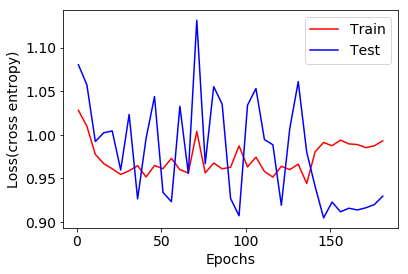

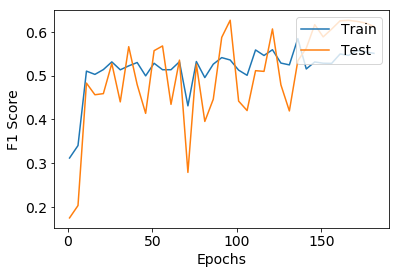

2017-11-22 13:47:41 -    1 epoch, loss:1.024, valid f1 score:0.337, test f1 score:0.174
2017-11-22 13:47:51 -   11 epoch, loss:0.973, valid f1 score:0.506, test f1 score:0.475
2017-11-22 13:48:00 -   21 epoch, loss:0.956, valid f1 score:0.522, test f1 score:0.444
2017-11-22 13:48:09 -   31 epoch, loss:0.958, valid f1 score:0.535, test f1 score:0.543
2017-11-22 13:48:18 -   41 epoch, loss:0.954, valid f1 score:0.520, test f1 score:0.434
2017-11-22 13:48:27 -   51 epoch, loss:0.970, valid f1 score:0.524, test f1 score:0.570
2017-11-22 13:48:36 -   61 epoch, loss:0.948, valid f1 score:0.543, test f1 score:0.521
2017-11-22 13:48:45 -   71 epoch, loss:0.951, valid f1 score:0.520, test f1 score:0.448
2017-11-22 13:48:54 -   81 epoch, loss:0.947, valid f1 score:0.539, test f1 score:0.428
2017-11-22 13:49:04 -   91 epoch, loss:0.942, valid f1 score:0.572, test f1 score:0.524
2017-11-22 13:49:13 -  101 epoch, loss:0.971, valid f1 score:0.488, test f1 score:0.317
2017-11-22 13:49:22 -  111 epoch

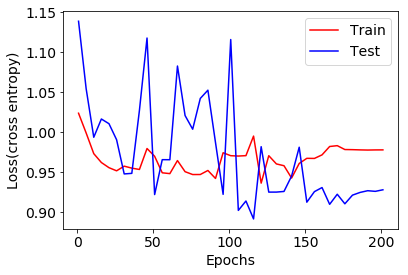

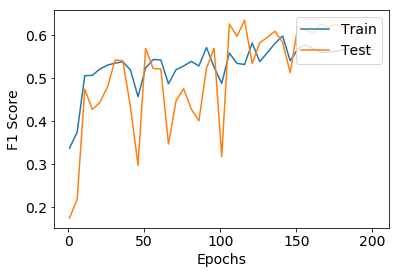

2017-11-22 13:53:07 -    1 epoch, loss:1.027, valid f1 score:0.330, test f1 score:0.174
2017-11-22 13:53:17 -   11 epoch, loss:0.967, valid f1 score:0.484, test f1 score:0.392
2017-11-22 13:53:26 -   21 epoch, loss:0.981, valid f1 score:0.446, test f1 score:0.315
2017-11-22 13:53:35 -   31 epoch, loss:0.950, valid f1 score:0.529, test f1 score:0.488
2017-11-22 13:53:44 -   41 epoch, loss:0.959, valid f1 score:0.527, test f1 score:0.560
2017-11-22 13:53:53 -   51 epoch, loss:0.968, valid f1 score:0.523, test f1 score:0.569
2017-11-22 13:54:02 -   61 epoch, loss:0.990, valid f1 score:0.435, test f1 score:0.311
2017-11-22 13:54:11 -   71 epoch, loss:0.969, valid f1 score:0.481, test f1 score:0.400
2017-11-22 13:54:20 -   81 epoch, loss:0.957, valid f1 score:0.526, test f1 score:0.537
2017-11-22 13:54:29 -   91 epoch, loss:0.968, valid f1 score:0.538, test f1 score:0.579
2017-11-22 13:54:38 -  101 epoch, loss:0.998, valid f1 score:0.505, test f1 score:0.579
2017-11-22 13:54:48 -  111 epoch

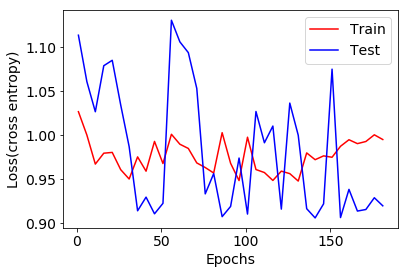

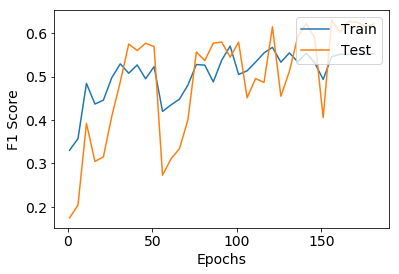

Average Validation F1 Score:0.5785346699941651
Average Testing F1 Score:0.5863759657019456
Average Top 5 Testing:0.6033280595791473


In [44]:
kf = KFold(n_splits=10)  # indice of 5 fold
saver = tf.train.Saver() # to store the model

early_stop_num = 5
best_valid_f1 = 0.0
best_test_f1 = 0.0

best_train_loss=None
best_test_loss=None
round_best_valid_f1_list = []
round_best_test_f1_list = []
x_axis = np.arange(0., epochs_num, 5)

with tf.Session() as sess:
    for cross_validation_round, (train_index, valid_index) in enumerate(kf.split(tweets_train, senti_train)):
        X_train_folds = tweets_train[train_index]
        y_train_folds = senti_train[train_index]
        X_valid_folds = tweets_train[valid_index]
        y_valid_folds = senti_train[valid_index]
        
        # prepare the training batch
        train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train_folds, y_train_folds)).batch(batch_size).repeat()
        train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
        train_next_batch = train_iterator.get_next()
        
        round_of_epochs = int(tweets_train.shape[0]/batch_size)
        train_loss = []
        test_loss  = []
        train_f1 = []
        test_f1 = []
        local_x_axis = []
        local_best_valid_f1 = 0.0
        local_best_test_f1 = 0.0
        not_better_count = 0
        
        # Initialize all variables
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())

        sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec

        for epochs in range(epochs_num): # starting the training process and set the epochs_num
            for _ in range(round_of_epochs):
                train, label = sess.run(train_next_batch) # Get the mini-batch data sample
                sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
            if epochs % 5 ==0:
                loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:X_valid_folds, y:y_valid_folds})
                t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
                train_loss.append(loss)
                test_loss.append(t_loss)
                train_f1.append(f1_score(y_valid_folds, pred, average='weighted'))
                test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
                local_x_axis.append(epochs+1)
            if epochs % 10 ==0:
                print("{} - {:4d} epoch, loss:{:.3f}, valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    epochs+1,
                    loss,
                    f1_score(y_valid_folds, pred, average='weighted'),
                    f1_score(senti_test, t_pred, average='weighted')
                    )
                )
                if train_f1[-1] > local_best_valid_f1:
                    local_best_valid_f1 = train_f1[-1] # assign the best valid value
                    local_best_test_f1 = test_f1[-1] # assign the test value of best valid value
                    not_better_count = 0 # reset the counter
                    
                    # if better then current best one, record it
                    if train_f1[-1] > best_valid_f1:
                        best_valid_f1 = train_f1[-1]
                    if test_f1[-1] > best_test_f1:
                        best_test_f1 = test_f1[-1]
                else:
                    not_better_count += 1
                    if not_better_count > 5:
                        print("No.{} Folds, Early Stop, {} Eopchs, best valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                            cross_validation_round+1,
                            epochs+1,
                            local_best_valid_f1,
                            local_best_test_f1
                        ))
                        round_best_valid_f1_list.append(local_best_valid_f1)
                        round_best_test_f1_list.append(local_best_test_f1)
                        

                        plt.rcParams['font.size'] = 14
                        plt.plot(local_x_axis, train_loss, 'r', local_x_axis, test_loss, 'b')
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('Loss(cross entropy)')
                        plt.show()
                        plt.clf()
                        plt.plot(local_x_axis, train_f1, local_x_axis, test_f1)
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('F1 Score')
                        plt.show()
                        break
print("Average Validation F1 Score:{}\nAverage Testing F1 Score:{}\nAverage Top 5 Testing:{}".format(
            sum(round_best_valid_f1_list)/10.0,
            sum(round_best_test_f1_list)/10.0,
            sum(sorted(round_best_test_f1_list, reverse=True)[:5])/5
        )
     )